### <font color='red'>AI004 - Explore Two Appropriate Models and Train (1)</font>

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import plotly.express as px
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import nltk

### Loading in the data

In [ ]:
#data source: https://huggingface.co/datasets/md_gender_bias
train_data = pd.read_json('data/md_gender_bias/funpedia/train.jsonl', lines = True)
test_data = pd.read_json('data/md_gender_bias/funpedia/test.jsonl', lines = True)
val_data = pd.read_json('data/md_gender_bias/funpedia/valid.jsonl', lines = True)

#combine pre-split datasets into one then apply train test split function twice
unified_data = train_data.append(test_data, ignore_index=True)
unified_data = unified_data.append(val_data, ignore_index=True)
print('nrows raw unified dataset:', len(unified_data))

nrows raw unified dataset: 29819


/var/folders/70/yx3rlp812k545ncgsfplvcbc0000gn/T/ipykernel_22684/3916703585.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  unified_data = train_data.append(test_data, ignore_index=True)
/var/folders/70/yx3rlp812k545ncgsfplvcbc0000gn/T/ipykernel_22684/3916703585.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  unified_data = unified_data.append(val_data, ignore_index=True)


### Start preprocessing (remove duplicate text)

In [ ]:

#drop all columns except text and label
unified_data = unified_data[['text', 'gender']]

#ensure all text lowercase so can compare for duplicates
for col in ['text', 'gender']:
    unified_data[col] = unified_data[col].str.lower()
    
#check duplicate rows in 'text' column
print('Number of duplicates:', len(unified_data[unified_data.duplicated(['text'])]))
#drop duplicates
unified_data.drop_duplicates(subset=['text'], inplace = True)
#recheck number of duplicates
print('Number of duplicates:', len(unified_data[unified_data.duplicated(['text'])]))

Number of duplicates: 1
Number of duplicates: 0


### Dropping 'gender-neutral' Class

In [ ]:
#drop NAs
unified_data.dropna(inplace = True)

#drop 'gender-neutral' class?
unified_data = unified_data[unified_data['gender'] != 'gender-neutral']

### Class Balancing

In [ ]:
#downsample 'male' to fix class imbalance
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy='majority', random_state= 0)
X = np.array(unified_data['text']).reshape(-1, 1)
y = np.array(unified_data['gender']).reshape(-1, 1)
X_undersample, y_undersample = undersample.fit_resample(X, y)

#flatten to 1D array in order to reocmbine into a new undersampled 'unified_data' dataframe
X_undersample = X_undersample.flatten()
y_undersample = y_undersample.flatten()

unified_data = pd.DataFrame({'text': X_undersample, 'gender': list(y_undersample)}, columns=['text', 'gender'])

### Label Encoding

In [ ]:
#convert two classes to new binary id column
unified_data['gender_id'] = unified_data['gender']
unified_data['gender_id'].replace(['male', 'female'], [0, 1], inplace = True)
print(unified_data[unified_data['gender'] == 'male'].head(3))
print(unified_data[unified_data['gender'] == 'female'].head(3))

                                                   text gender  gender_id
4457  holy moly! josh brown guest starred in the sho...   male          0
4458  jim colver has been serving the residents of a...   male          0
4459  born in cleveland, ford was luckily taken by t...   male          0
                                                text  gender  gender_id
0   danielle frenkel is a high jumper born in israel  female          1
1  tania mihailuk is a politician who was born in...  female          1
2  juliet taylor is a woman who works as a castin...  female          1


### Stopwords

In [ ]:
#import sklearn stop words
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

stop_words = list(ENGLISH_STOP_WORDS)
print(stop_words)
print(len(stop_words))
my_stop_words = stop_words.copy()

#to add stop words, e.g.
#my_stop_words = text.ENGLISH_STOP_WORDS.union(["book"])

#word_remove = ['he', 'she', 'him', 'her', 'hers', 'his', 'himself', 'herself']
word_remove = []
for i in my_stop_words:
    if i in word_remove:
        my_stop_words.remove(i)

my_stop_words = frozenset(my_stop_words)

['ltd', 'ours', 'may', 'thus', 'still', 'below', 'never', 'which', 'back', 'per', 'each', 'before', 'couldnt', 'everything', 'throughout', 'nothing', 'i', 'my', 'either', 'five', 'seem', 'its', 'thereby', 'to', 'become', 'forty', 'together', 'without', 'whole', 'inc', 'wherever', 'found', 'up', 'however', 'almost', 'upon', 'next', 'besides', 'him', 'etc', 'whatever', 'four', 'whoever', 'someone', 'full', 'once', 'ten', 'hasnt', 'had', 'except', 'eleven', 'in', 'they', 'whereas', 'nobody', 'what', 'also', 'now', 'latter', 'anywhere', 'un', 'during', 'rather', 'among', 'amongst', 'there', 'if', 'them', 'meanwhile', 'but', 'by', 'will', 'ever', 'too', 'or', 'would', 'since', 'system', 'enough', 'could', 'hereby', 'hereupon', 'formerly', 'than', 'hence', 'ourselves', 'as', 'find', 'onto', 'whose', 'do', 'part', 'behind', 'anyhow', 'about', 'be', 're', 'own', 'amoungst', 'who', 'yet', 'until', 'cannot', 'somewhere', 'hereafter', 'nor', 'mill', 'often', 'along', 'sometimes', 'three', 'of', '

In [ ]:
def stop_words_search(string):
        if string in stop_words:
            print('yes, present in stop words list')
        else:
            print('no, not present in stop words list')
            
stop_words_search('man')
stop_words_search('woman')
stop_words_search('girl')
stop_words_search('boy')

no, not present in stop words list
no, not present in stop words list
no, not present in stop words list
no, not present in stop words list


In [ ]:

#https://www.nltk.org/data.html   instructions for manual download
#https://www.nltk.org/nltk_data/
#SLL cert error so need to download manually from above website then move into relevant subfolder of /usr/local/share/nltk_data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>
[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>
[nltk_data] Error loading omw-1.4: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>


False

### Tokenization

In [ ]:
#https://courses.cs.duke.edu/spring14/compsci290/assignments/lab02.html
#https://www.kirenz.com/post/2021-12-11-text-mining-and-sentiment-analysis-with-nltk-and-pandas-in-python/text-mining-and-sentiment-analysis-with-nltk-and-pandas-in-python/

from nltk.tokenize import word_tokenize   #requires nltk.download('punkt') but SSL cert error
from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist

#regex here already removes punctuation
#regex here includes tokens that have at least one letter, removing numbers from consideration (can be used in token_pattern argument too)
regexp = RegexpTokenizer(u'(?ui)\\b\\w*[a-z]+\\w*\\b')
unified_data['text_token']=unified_data['text'].apply(regexp.tokenize)

#remove stopwords
unified_data['text_token'] = unified_data['text_token'].apply(lambda x: [item for item in x if item not in my_stop_words])

#keep only words longer than 1 character
unified_data['text_string'] = unified_data['text_token'].apply(lambda x: ' '.join([item for item in x if len(item)>1]))
unified_data['text_token'] = unified_data['text_token'].apply(lambda x: [item for item in x if len(item)>1])

#create list of all words
all_words = ' '.join([word for word in unified_data['text_string']])
tokenized_words = word_tokenize(all_words)

#create a frequency distribution which records the number of times each word has occurred:
fdist = FreqDist(tokenized_words)
fdist

FreqDist({'born': 555, 'american': 470, 'great': 388, 'like': 351, 'known': 299, 'amazing': 281, 'actress': 272, 'work': 263, 'player': 257, 'love': 247, ...})

##### an alternative way to tokenize
- from nltk.tokenize import TreebankWordTokenizer   #equivalent to word_tokenize just doesn't require a download
- tokenize all_words
- tokenizer = TreebankWordTokenizer()
- tokenized_words = tokenizer.tokenize(all_words)

<AxesSubplot:>

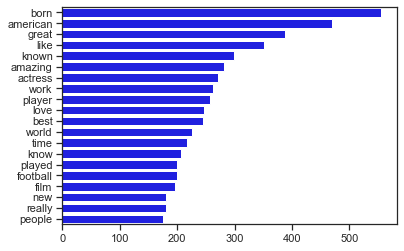

In [ ]:
# Obtain top 10 words
n = 20
top_n = fdist.most_common(n)

# Create pandas series to make plotting easier
fdist_pseries = pd.Series(dict(top_n))

import seaborn as sns
sns.set_theme(style="ticks")

sns.barplot(y=fdist_pseries.index, x=fdist_pseries.values, color='blue')

### Lemmatizing (alternative to stemming) - not working

#LEMMATIZING - NLTK lemmatizing doesn't work very well seemingly
#Now we can use our fdist dictionary to drop words which occur less than a certain amount of times (usually we use a value of 3 or 4)
#argument in Tfidfvectorizer that does the same
`unified_data['text_string_fdist'] = unified_data['text_token'].apply(lambda x: ' '.join([item for item in x if fdist[item]>=3]))`

`from nltk.stem import WordNetLemmatizer
wordnet_lem = WordNetLemmatizer()
unified_data['text_string_lem'] = unified_data['text_string_fdist'].apply(wordnet_lem.lemmatize)`
#sometimes no words to lemmatize so can compare two columns to verify
#check if the columns are equal
`unified_data['is_equal']=(unified_data['text_string_fdist']==unified_data['text_string_lem'])
print(unified_data.is_equal.value_counts())`

#prep for word cloud
`all_words_lem = ' '.join([word for word in unified_data['text_string_lem']])
print(all_words_lem[0:1000])
tokenized_words_new = word_tokenize(all_words_lem)`

#simplify dataframe
`unified_data = unified_data[['text_string_lem', 'gender_id', 'gender']]
print(unified_data.head(3))`

### Stemming

In [ ]:
#STEMMING
from nltk.stem.snowball import SnowballStemmer
#use English stemmer
stemmer = SnowballStemmer("english")
unified_data['stemmed'] = unified_data['text_token'].apply(lambda x: ' '.join([stemmer.stem(y) for y in x]))

#prep for word cloud
all_words_stem = ' '.join([word for word in unified_data['stemmed']])
print(all_words_stem[0:1000])
tokenized_words_new = word_tokenize(all_words_stem)

#simplify dataframe
unified_data = unified_data[['stemmed', 'gender_id', 'gender']]
print(unified_data.head(3))

daniell frenkel high jumper born israel tania mihailuk politician born australia juliet taylor woman work cast director margaret carolin rudd born britain notori femal forger retta scott american artist die cice mari barker fantasi illustr depict fairi flower che zahara work malay activist fought hard women children right singapor feel gratitud evelyn dunbar help women land armi world war ii pave way peac geraldin kattnig born februari austria favor actress ami thomson hard scienc fiction write feminist pamela mather score best bowl figur women cricket world cup eileen montesin somewhat popular maltes actress tv person have appear programm love novel bloodi jack amaz stori orphan girl london man love dr moira kinross mactaggert marvel comic know come torun polish contralto born copernicus charl work wall histori success depict african american histori consid greatest achiev great kendra realiti televis seri grace air start june mari arriv conclus year old skin colour use judg love watc

#### WORD CLOUD - STEMMED WORDS

Word Cloud - STEMMED Words


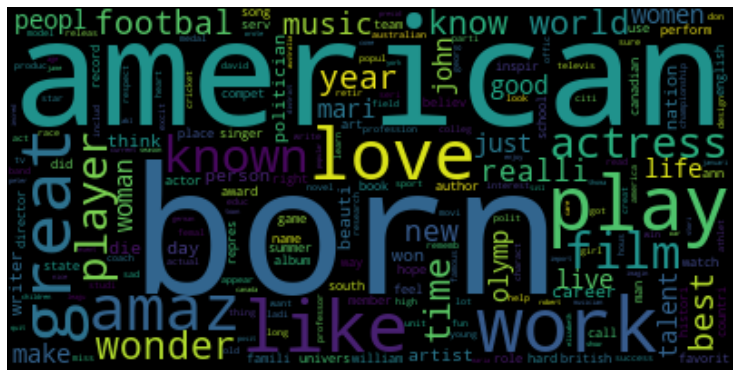

In [ ]:
%matplotlib inline

#word cloud using frequencies to infer word sizing
#convert FreqDict object to dictionary
fdist_new = FreqDist(tokenized_words_new)
fdist_dict = dict(fdist_new)

import matplotlib.pyplot as plt
from wordcloud import WordCloud

print('Word Cloud - STEMMED Words')
wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=fdist_dict)
plt.figure(figsize=(13, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Word Cloud - UNSTEMMED Words


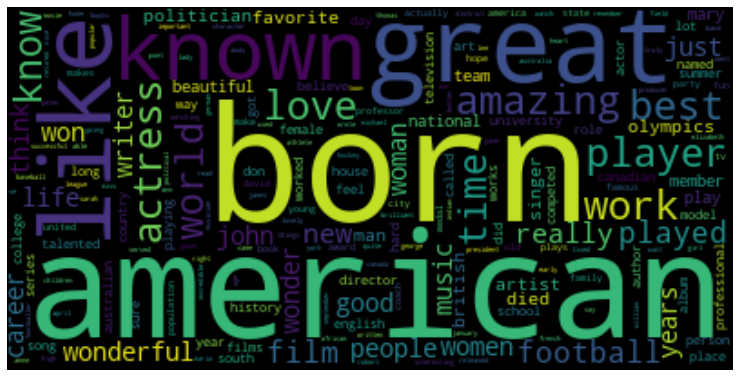

In [ ]:
%matplotlib inline

#word cloud using frequencies to infer word sizing
#convert FreqDict object to dictionary
fdist = FreqDist(tokenized_words)
fdist_dict = dict(fdist)

import matplotlib.pyplot as plt
from wordcloud import WordCloud

print('Word Cloud - UNSTEMMED Words')
wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=fdist_dict)
plt.figure(figsize=(13, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Vectorizing

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

#https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
tfidf = TfidfVectorizer(max_features = 10000, 
                        max_df=0.5, 
                        encoding='utf-8', 
                        ngram_range=(1, 3), 
                        stop_words=None,   #already done above
                        lowercase = True,   #already done above
                        token_pattern = u'(?ui)\\b\\w*[a-z]+\\w*\\b',   #same as before
                        use_idf = True)

#### Choose to stem

In [ ]:
X = tfidf.fit_transform(unified_data['stemmed']).toarray()

#### Choose to lemmatize

In [ ]:
#X = tfidf.fit_transform(unified_data['text_string_lem']).toarray()

In [ ]:
y = unified_data['gender_id']

#stratify = y should only be used for imbalanced classes but this has already been corrected so no need but wil artificially improve especialy if one class more easy to classify than another
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.2) 

print('percentage data that is TRAIN:', round((len(X_train)/len(unified_data))*100, 2))
print('percentage data that is TEST:', round((len(X_test)/len(unified_data))*100, 2))

percentage data that is TRAIN: 80.0
percentage data that is TEST: 20.0


#### Verify Tfidf working properly

In [ ]:
#feature_names = cv.get_feature_names_out()
feature_names = tfidf.get_feature_names_out()
print(feature_names)
print('-'*50)
print('Number of features extracted:', len(feature_names))

['10th' '11th' '13th' ... 'zombi' 'zone' 'zoo']
--------------------------------------------------
Number of features extracted: 10000


In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier

#define model
#https://xgboost.readthedocs.io/en/stable/parameter.html
#control imbalanced classes with 'scale_pos_weights' (default = 1) but use quick formula sum(negative instances) / sum(positive instances)
model_xgb = XGBClassifier(n_estimators = 100, max_depth = 5, random_state = 0, verbosity = 1, learning_rate = 0.3, objective = 'binary:logistic', n_jobs = 4)

#grid search
#https://machinelearningmastery.com/tune-learning-rate-for-gradient-boosting-with-xgboost-in-python/
#https://machinelearningmastery.com/xgboost-for-imbalanced-classification/
#https://machinelearningmastery.com/tune-number-size-decision-trees-xgboost-python/

In [ ]:
from sklearn.metrics import get_scorer_names

get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_

In [ ]:
from sklearn.model_selection import cross_val_score
from statistics import mean
from sklearn.model_selection import GridSearchCV

#https://machinelearningmastery.com/how-to-configure-k-fold-cross-validation/

#Tour of Evaluation Metrics for Imbalanced Classification
#https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/

k = 1

def evaluate_model(cross_val):
    #GRID SEARCH CODE
    #-----
    learning_rate = [0.3]
    #n_estimators = [100]
    n_estimators = [5]
    param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators)
    grid_search = GridSearchCV(model_xgb, param_grid, scoring="accuracy", cv=cross_val, n_jobs=-1, verbose = 0)
    grid_result = grid_search.fit(X_train, y_train)
    
    #summarize performance
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    #-----
    
    #NON-GRID SEARCH CODE - (uncomment all below)
    #evaluate model
    #n_jobs=-1 means using all processors
    #scores = cross_val_score(model_xgb, X_train, y_train, scoring='accuracy', cv=cross_val, n_jobs=-1, verbose = 0)

    #summarize performance
    #print('Accuracy: %.3f' % mean(scores))

    #return mean(scores), min(scores), max(scores)
    
#means, mins, maxs = list(), list(), list()

https://towardsdatascience.com/pooled-roc-with-xgboost-and-plotly-553a8169680c#:~:text=To%20get%20a%20ROC%20curve,validation%20and%20got%20500%20results.

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

folds = range(1, k+1)

for fold_num in tqdm(folds):
	#define test condition
	#cross_val = RepeatedStratifiedKFold(n_splits=k, n_repeats=2, random_state=0)
	#cross_val = StratifiedKFold(n_splits=k, random_state=0, shuffle=True)
	cross_val = KFold(n_splits=k, random_state=0, shuffle=True)

	#GRID SEARCH CODE
	#-----
	evaluate_model(cross_val)
	print('> folds=%d' % (fold_num))
	#-----

	#NON-GRID SEARCH CODE - (uncomment all below)
	# evaluate k value
	#k_mean, k_min, k_max = evaluate_model(cross_val)

	# report performance
	#print('> folds=%d, accuracy=%.3f (%.3f,%.3f)' % (fold_num, k_mean, k_min, k_max))

	# store mean accuracy
	#means.append(k_mean)

	# store min and max relative to the mean
	#mins.append(k_mean - k_min)
	#maxs.append(k_max - k_mean)


  0%|          | 0/2 [00:00<?, ?it/s]

Best: 0.688402 using {'learning_rate': 0.3, 'n_estimators': 100}
0.688402 (0.003409) with: {'learning_rate': 0.3, 'n_estimators': 100}
> folds=1
Best: 0.688402 using {'learning_rate': 0.3, 'n_estimators': 100}
0.688402 (0.003409) with: {'learning_rate': 0.3, 'n_estimators': 100}
> folds=2


In [ ]:
#fit model to training data
#https://xgboost.readthedocs.io/en/stable/parameter.html
model_xgb.fit(X_train, y_train)

#make predictions for test data
y_pred = model_xgb.predict(X_test)
y_pred = [round(value) for value in y_pred]

### <font color='red'>AI005 - Create Evaluation Visualizations (1)</font>

Accuracy: 73.079%
              precision    recall  f1-score   support

      female       0.81      0.60      0.69       888
        male       0.68      0.86      0.76       895

    accuracy                           0.73      1783
   macro avg       0.75      0.73      0.73      1783
weighted avg       0.75      0.73      0.73      1783



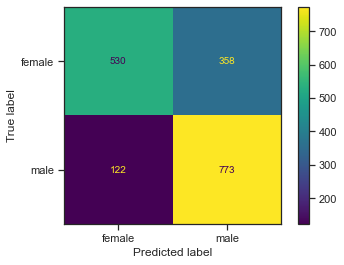

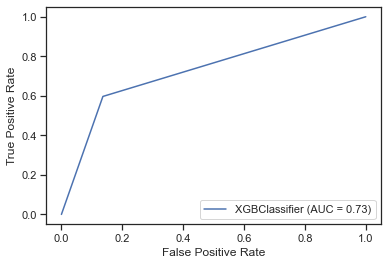

In [ ]:
# evaluate predictions
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, roc_curve, auc, plot_roc_curve, RocCurveDisplay

y_test_alt = pd.Series(y_test)
y_test_alt.replace(0, 'male', inplace = True)
y_test_alt.replace(1, 'female', inplace = True)
y_pred_alt = pd.Series(y_pred)
y_pred_alt.replace(0, 'male', inplace = True)
y_pred_alt.replace(1, 'female', inplace = True)

accuracy = accuracy_score(y_test, y_pred)

print('Accuracy: %.3f%%' % (accuracy * 100.0))

print(classification_report(y_test_alt, y_pred_alt))
ConfusionMatrixDisplay.from_predictions(y_test_alt, y_pred_alt)

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='XGBClassifier')
display.plot()
plt.show()

### <font color='red'>AI004 - Explore Two Appropriate Models and Train (2)</font>

In [ ]:
from sklearn.naive_bayes import MultinomialNB
#alpha default = 1 but also happens to be optimum
model_nb = MultinomialNB(alpha = 1)

In [ ]:
from sklearn.model_selection import cross_val_score
from statistics import mean
from sklearn.model_selection import GridSearchCV

#https://machinelearningmastery.com/how-to-configure-k-fold-cross-validation/

#Tour of Evaluation Metrics for Imbalanced Classification
#https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/

def evaluate_model(cross_val):

    alpha = [0, 0.5, 1, 1.5, 2, 2.5, 3]
    param_grid = dict(alpha=alpha)
    grid_search = GridSearchCV(model_nb, param_grid, scoring="accuracy", cv=cross_val, n_jobs=-1, verbose = 0)
    grid_result = grid_search.fit(X_train, y_train)
    
    #summarize performance
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

folds = range(1, k+1)

for fold_num in tqdm(folds):
	#define test condition
	cross_val = KFold(n_splits=k, random_state=0, shuffle=True)

	evaluate_model(cross_val)
	print('> folds=%d' % (fold_num))


  0%|          | 0/2 [00:00<?, ?it/s]

/Users/joshua.grefte/Library/Python/3.10/lib/python/site-packages/sklearn/naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/joshua.grefte/Library/Python/3.10/lib/python/site-packages/sklearn/naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


Best: 0.732435 using {'alpha': 1}
0.680691 (0.006827) with: {'alpha': 0}
0.731174 (0.001019) with: {'alpha': 0.5}
0.732435 (0.003684) with: {'alpha': 1}
0.731454 (0.003543) with: {'alpha': 1.5}
0.730893 (0.002983) with: {'alpha': 2}
0.729210 (0.005507) with: {'alpha': 2.5}
0.727667 (0.005648) with: {'alpha': 3}
> folds=1


/Users/joshua.grefte/Library/Python/3.10/lib/python/site-packages/sklearn/naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/joshua.grefte/Library/Python/3.10/lib/python/site-packages/sklearn/naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


Best: 0.732435 using {'alpha': 1}
0.680691 (0.006827) with: {'alpha': 0}
0.731174 (0.001019) with: {'alpha': 0.5}
0.732435 (0.003684) with: {'alpha': 1}
0.731454 (0.003543) with: {'alpha': 1.5}
0.730893 (0.002983) with: {'alpha': 2}
0.729210 (0.005507) with: {'alpha': 2.5}
0.727667 (0.005648) with: {'alpha': 3}
> folds=2


In [ ]:
#fit model to training data
model_nb.fit(X_train, y_train)

#make predictions for test data
y_pred = model_nb.predict(X_test)
y_pred = [round(value) for value in y_pred]

### <font color='red'>AI005 - Create Evaluation Visualizations (2)</font>

Accuracy: 79.361%
              precision    recall  f1-score   support

      female       0.79      0.80      0.79       888
        male       0.80      0.79      0.79       895

    accuracy                           0.79      1783
   macro avg       0.79      0.79      0.79      1783
weighted avg       0.79      0.79      0.79      1783



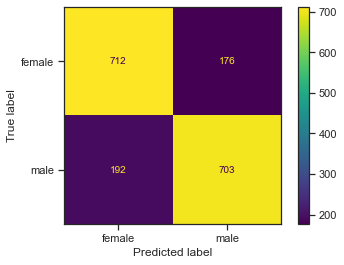

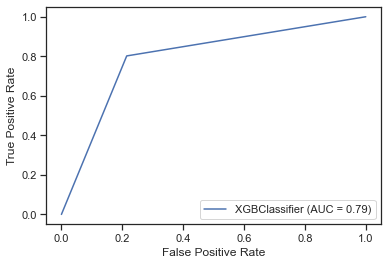

In [ ]:
# evaluate predictions
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, roc_curve, auc, plot_roc_curve, RocCurveDisplay

y_test_alt = pd.Series(y_test)
y_test_alt.replace(0, 'male', inplace = True)
y_test_alt.replace(1, 'female', inplace = True)
y_pred_alt = pd.Series(y_pred)
y_pred_alt.replace(0, 'male', inplace = True)
y_pred_alt.replace(1, 'female', inplace = True)

accuracy = accuracy_score(y_test, y_pred)

print('Accuracy: %.3f%%' % (accuracy * 100.0))

print(classification_report(y_test_alt, y_pred_alt))
ConfusionMatrixDisplay.from_predictions(y_test_alt, y_pred_alt)

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='XGBClassifier')
display.plot()
plt.show()